In this notebook we will be fitting a random forest to our model. We will proceed with the same filters as done in our Logistic model (minimum minutes played and games played)

# Model

A random forest is considered an "Ensemble" Model. These types of models take in a large number of different models that are performing slightly better than chance, and then combine them into a stronger model. For a random forest, this means that `n-estimator` total decision trees are created, then their results are combined (by  picking the result the majority of trees agree with). Each tree is trained on random subsets of the data, with random subsets of the features.

This also begs the question, why do these models work? We can consider a simple example, where we can imagine that we have a `n` total models that predict the correct results, say 51% of the time. If we assume each model is independent in their predictions, then we can utilize a bernoulli model and apply the law of large numbers. In simpler terms, we can imagine every model is like a coin flip, where the true result is a heads (with 51% chance), and the incorrect result is tails (49%). If we consider an ensemble of 10 models, then we will simply consider how many heads we have vs tails. If we have more heads, we pick that result, and more tails we pick the other result. Clearly, this will lead to quite a bit of variance in our results, and we will often pick the wrong result. But imagine we are flipping 1000 coins, or even 100000 coins. We see that we will have, with probability approaching 1, that as our number of models grow, the number of heads will be greater than the number of tails. In our case, the independence assumption is violated since we utilize the same data, however, we can still yield good results even without this assumption. 

In [5]:
import pandas as pd
import numpy as np

In [6]:
nba_train = pd.read_csv('Data_Scripting_Cleaning/Full_data/Training_Sets/nba_train.csv')
nba_test = pd.read_csv('Data_Scripting_Cleaning/Full_data/Test_Sets/nba_test.csv')


In [7]:
min_minutes = nba_train[(nba_train['all_nba_c_year']==1)].MP.min()
min_G = nba_train[(nba_train['all_nba_c_year']==1)].G.min()
nba_filt_train = nba_train[(nba_train['MP']>=min_minutes) & (nba_train['G']>=min_G)]
nba_filt_test = nba_test[(nba_test['MP']>=min_minutes) & (nba_test['G']>=min_G)]

y_train = nba_filt_train['all_nba_c_year']

y_test = nba_filt_test['all_nba_c_year']

### Fitting the Model

To fit this model we will consider a grid of hyper-parameters. Since this grid is quite large (7200), we will utilize a randomized search where we consider 500 random subsets of the hyper-parameters.

We can also consider what these hyper-parameters mean.
1) n_estimators: How many decision trees will be created in total
2) max_depth: The longest path between the root node and the leaf. This is essentially controlling how many splits are allowed.
3) min_samples_lead: Minimum number of samples to required for a leaf node. This determines how specific a leaf can be.
4) min_samples_split: Minimum number of samples a node must have for it to be split
5) max_features: Maximum number features randomly selected for each tree.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Now we will fit a random forest model to the data. We will fit this data into a pipeline to scale the data and then fit the model.

num_features = ['Age','G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS',
       'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'W',
       'num_all_nba']
cat_features = ['Tm']


preprocessor = ColumnTransformer(
    [("select", "passthrough", num_features),
     ("ohe", OneHotEncoder(handle_unknown="ignore"), cat_features)],
     remainder="drop"
)

preprocessor.fit(nba_filt_train)

ColumnTransformer(transformers=[('select', 'passthrough',
                                 ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
                                  '3P', '3PA', '3P%', '2P', '2PA', '2P%',
                                  'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
                                  'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                                  'PTS', 'PER', 'TS%', '3PAr', 'FTr', ...]),
                                ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                 ['Tm'])])

In [9]:
X_train = pd.DataFrame(preprocessor.transform(nba_filt_train), columns = preprocessor.get_feature_names_out())
X_test = pd.DataFrame(preprocessor.transform(nba_filt_test), columns = preprocessor.get_feature_names_out())

In [6]:
#Now we can fit our Random Forest model to the data.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(random_state=0)
param_grid = {
   'n_estimators': [100, 200, 300, 400, 500],
   'max_depth': [5, 10, 15, 20, 25],
   'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 40],
   'min_samples_leaf': [1, 2, 5, 10, 15, 20],
   'max_features': [ 'sqrt', 'log2', 0.2, .4]
}


CV_rfc = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv= 5,
                            random_state=0, n_iter=500)
CV_rfc.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=500,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25],
                                        'max_features': ['sqrt', 'log2', 0.2,
                                                         0.4],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              25, 30, 40],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=0)

In [2]:
CV_rfc.best_params_


NameError: name 'CV_rfc' is not defined

### Results

Now we may look at how our model did on our test set. 

We see that we have 82% Precision, and 75% recall. This is similar to the results we had from our logistic regression prior. 

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, CV_rfc.predict(X_test), target_names=['Not All-NBA', 'All-NBA']))

              precision    recall  f1-score   support

 Not All-NBA       0.96      0.98      0.97       819
     All-NBA       0.82      0.75      0.78       123

    accuracy                           0.95       942
   macro avg       0.89      0.86      0.88       942
weighted avg       0.94      0.95      0.94       942



Looking at our confusion matrix we have the following:

In [43]:
pd.crosstab(y_test, CV_rfc.predict(X_test), rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,799,20,819
1,31,92,123
All,830,112,942


We can view our false positives as:

In [30]:
#add probabilities to test dataframe
nba_test_prob = nba_filt_test.copy()
nba_test_prob['prob_all_nba'] = CV_rfc.predict_proba(X_test)[:,1]

In [31]:
#False Positives
nba_test_prob[(CV_rfc.predict(X_test)==1) & (y_test==0)][['Player','year','num_all_nba','prob_all_nba']].sort_values(by='year', ascending=False)

,Player,year,num_all_nba,prob_all_nba
463,Ja Morant,2023,1,0.595865
577,James Harden,2023,7,0.563259
2591,Kevin Durant,2023,10,0.717942
3050,Rudy Gobert,2022,4,0.684923
851,James Harden,2021,7,0.655188
3168,Joel Embiid,2020,2,0.533650
3419,Karl-Anthony Towns,2017,0,0.574464
2983,Pau Gasol,2012,3,0.577528
2650,Carmelo Anthony,2011,4,0.554912
1552,Paul Pierce,2011,4,0.640203


For our False negatives we have:

In [32]:
#False Negatives
nba_test_prob[(CV_rfc.predict(X_test)==0) & (y_test==1)][['Player','year','num_all_nba','prob_all_nba']].sort_values(by='year', ascending=False)

,Player,year,num_all_nba,prob_all_nba
397,Chris Paul,2021,9,0.492275
1446,Ben Simmons,2020,0,0.087168
2359,Pascal Siakam,2020,0,0.291353
3377,Joel Embiid,2018,0,0.413873
2491,Draymond Green,2017,1,0.324777
3358,Dwight Howard,2014,7,0.229850
495,Tony Parker,2012,1,0.410776
2448,Paul Pierce,2009,3,0.280721
1010,Chauncey Billups,2009,2,0.178562
3005,Shaquille O'Neal,2009,13,0.119555


In [44]:
coef_df = pd.DataFrame({'coefs':CV_rfc.best_estimator_.feature_importances_,
                          'features':X_train.columns})
coef_df_nz = coef_df[coef_df['coefs']!=0]
coef_df_nz.sort_values(by='coefs', ascending=False, inplace=True)

/var/folders/h0/v8b9tbrn3t18vwzvgn1npc5c0000gn/T/ipykernel_31056/3950039097.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coef_df_nz.sort_values(by='coefs', ascending=False, inplace=True)


We can also view which coefficients made the most impact on the model. We see similar to our logistic regression, VORP was one of the strongest features in prediciting All-NBA status. 

In [19]:
import altair as alt
alt.Chart(coef_df_nz[0:40]).mark_bar().encode(
    y='coefs',
    x=alt.Y('features', sort='-y'))

alt.Chart(...)

As a final metric we can also view the ROC curve. This plots the true positive rate vs the false positive rate. To measure how effective our classifier is, we consider area under the curve (AUC). A perfect classifier would have an AUC of 1, while ours has an AUC of .974. This indicates our classifier is performing well, but we may still want to explore further models.

Text(0, 0.5, 'True Positive Rate')

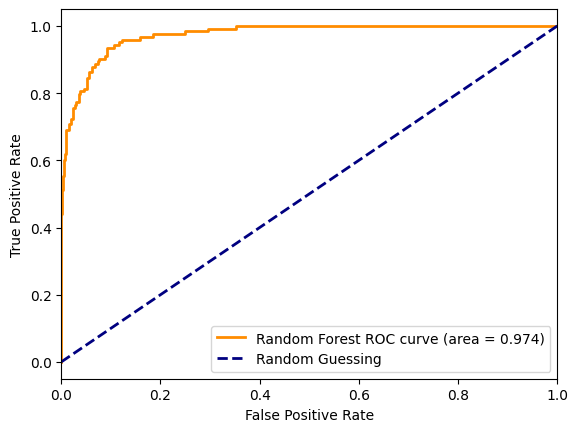

In [40]:
#We can also look at the ROC curve for the model.
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, CV_rfc.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
#plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
            lw=2, label='Random Forest ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [10]:
#Now we can try to do some feature selection using a recursive feature elimination method.
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

rf_mod = RandomForestClassifier(random_state=0, n_estimators= 100, min_samples_split= 25, min_samples_leaf= 2, max_features= .2, max_depth= 25)

rfecv = RFECV(estimator=rf_mod, step=1, cv=5,
                scoring='recall')
rfecv.fit(X_train, y_train)


RFECV(cv=5,
      estimator=RandomForestClassifier(max_depth=25, max_features=0.2,
                                       min_samples_leaf=2, min_samples_split=25,
                                       random_state=0),
      scoring='recall')

In [20]:
preprocessor.get_feature_names_out()[rfecv.get_support()]

array(['select__Age', 'select__G', 'select__GS', 'select__MP',
       'select__FG', 'select__FGA', 'select__FG%', 'select__3P',
       'select__3PA', 'select__3P%', 'select__2P', 'select__2PA',
       'select__2P%', 'select__eFG%', 'select__FT', 'select__FTA',
       'select__FT%', 'select__ORB', 'select__DRB', 'select__TRB',
       'select__AST', 'select__STL', 'select__BLK', 'select__TOV',
       'select__PF', 'select__PTS', 'select__PER', 'select__TS%',
       'select__3PAr', 'select__FTr', 'select__ORB%', 'select__DRB%',
       'select__TRB%', 'select__AST%', 'select__STL%', 'select__BLK%',
       'select__TOV%', 'select__USG%', 'select__OWS', 'select__DWS',
       'select__WS', 'select__WS/48', 'select__OBPM', 'select__DBPM',
       'select__BPM', 'select__VORP', 'select__W', 'select__num_all_nba',
       'ohe__Tm_BKN', 'ohe__Tm_BOS', 'ohe__Tm_DET', 'ohe__Tm_NOP',
       'ohe__Tm_PHX', 'ohe__Tm_SAC'], dtype=object)

In [22]:
y_pred_rfecv = rfecv.predict(X_test)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rfecv, target_names=['Not All-NBA', 'All-NBA']))

              precision    recall  f1-score   support

 Not All-NBA       0.96      0.98      0.97       819
     All-NBA       0.82      0.74      0.78       123

    accuracy                           0.94       942
   macro avg       0.89      0.86      0.87       942
weighted avg       0.94      0.94      0.94       942



In [25]:
pd.crosstab(y_test, y_pred_rfecv, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,799,20,819
1,32,91,123
All,831,111,942
